In [124]:
import contextlib
from math import sqrt, log, log10, exp
import mmap
import os
from struct import Struct


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

%matplotlib inline  

mhr_dataset_filename = 'c:/data/axaf_mrh_tot_freq_tot.csv'

In [2]:
def moving_average(a, n=3) :
    cum = np.cumsum(a, dtype=float)
    ret = cum + 0
    for i in range(len(ret)):
        if i < n:
            ret[i] = cum[i] / (i+1)
        else:
            ret[i] = (cum[i] - cum[i-n])/n
    return ret

def arrray_iterator(x, y):
    size = x.shape[0]
    i = 0
    while True:
        yield (x[i % size], y[i % size])
        i += 1
        
def get_binary_format(p):
    return Struct('<' + str(p + 1) + 'f')

def save_dataset(x, y):
    binary_io = get_binary_format(len(x[0]))
    with open('data.ml', 'wb') as data_file:
        for i in range(len(x)):
            line = list(x[i]) + [y[i]]
            data_file.write(binary_io.pack(*line))
        
def file_iterator(file_name, p, rolling=False, exposure=False):
    binary_io = get_binary_format(p + 1 if exposure else 0)
    with open(file_name, 'rb') as data_file:
        file_size = os.fstat(data_file.fileno()).st_size
        with contextlib.closing(mmap.mmap(data_file.fileno(), 0, access=mmap.ACCESS_READ)) as m:
            i = 0
            while True:
                pt = i * binary_io.size
                if not rolling and pt >= file_size:
                    break
                pt %= file_size
                values = binary_io.unpack_from(m, pt)
                if exposure:
                    yield (np.array(values[:-2]), values[-2], values[-1])
                else:
                    yield (np.array(values[:-1]), values[-1])
                i += 1

In [3]:
def fit_online(xy_iterator, fit_intercept=True, nb_adaptative_steps=1000, moving_average_size=1000, family=None,
               p1=0, p2=0, max_iterations = 1000000, exposure=False, average_size=100000):
    a = 0.2
    alphas = np.zeros(nb_adaptative_steps + 1)
    intercept = 0
    p = len(next(xy_iterator)[0])
    b = np.zeros(p)
    errors = np.zeros(max_iterations)
    exposure = 1
    
    for i in range(1, max_iterations):
        if exposure:
            x, y, exposure = next(xy_iterator)
        else:
            x, y = next(xy_iterator)
        y_pred = np.inner(x, b) + intercept + log(exposure)
        if family == 'poisson':
            y_pred = exp(y_pred)
        e = y_pred - y
        e_regularized = e + np.sum(p1 * np.abs(b) + p2 * np.square(b))
        if fit_intercept:
            intercept -= a * e * 10
        b -= (a * e) * x + p1 * np.sign(b) + p2 * b
        errors[i-1] = abs(e)

        if i <= nb_adaptative_steps:
            y_pred = np.inner(x, b) + intercept + log(exposure)
            if family == 'poisson':
                y_pred = exp(y_pred)
            e_updated = y_pred - y + np.sum(p1 * np.abs(b) + p2 * np.square(b))
            if abs(e_updated) > abs(e_regularized):
                a *= (1 - 0.999**min(i, 1000))
            else:
                a *= 1.1
            alphas[i-1] = a
            if i == nb_adaptative_steps:
                a = np.average(alphas)
                alphas[i] = a
            
        if i> 100000 and i % 10000 == 0:
            log_trailing_error = np.average(errors[i-moving_average_size:i])
            log_trailing_error_before = np.average(errors[i-max(i // 10, 10000):i-max(i // 10, 10000) + moving_average_size])
            if log_trailing_error >= log_trailing_error_before:
                break
    
    a = np.average(alphas)
    nb_betas = max(i, average_size)
    intercepts = 0
    betas = np.zeros(p)
    for j in range(nb_betas):
        if exposure:
            x, y, exposure = next(xy_iterator)
        else:
            x, y = next(xy_iterator)
        y_pred = np.inner(x, b) + intercept + log(exposure)
        if family == 'poisson':
            y_pred = exp(y_pred)
        e = y_pred - y
        if fit_intercept:
            intercept -= a * e
        b -= (a * e) * x + p1 * np.sign(b) + p2 * b
        intercepts += intercept
        betas += b 
    intercepts /= nb_betas
    betas  /= nb_betas
    
    return (i, intercepts, betas, alphas, errors[:i])

In [ ]:
p = 1000
n = 100000

beta = np.random.random(p) #* 2 - 1

x = np.random.random(p * n).reshape((n, p,))
y = np.dot(x, beta) + np.random.normal(size=n) / 1000 + 1

save_dataset(x, y)

In [ ]:
#i, intercept, b, l, errors = fit_online(arrray_iterator(x, y), p1=0)
i, intercept, b, l, errors = fit_online(file_iterator('data.ml', p,  rolling=True), p1=0, family='poisson')
trailing_errors = moving_average(errors, 1000)

print('minimum achieved at :', np.argmin(errors))
print('lambda : ', l[-1])
print('error : ', errors[-1])
print(i, 'th iteration')
print('intercept : ', intercept)
print('Trailing error : ', trailing_errors[-1:])
print("Difference of coefficient :", np.sum(abs(beta - b)), abs((b-beta)[:5]))
print('NB of non null coefficients : ', np.count_nonzero(np.greater(b, 0.01)))
print("Mean squared error : %.2f" % np.mean(np.square((np.inner(x, b) + intercept - y))))
e = np.average(np.abs(np.inner(x, b) + intercept - y))
print("Sum of log10 abs error : ", log10(e))

fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(errors + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(trailing_errors + 1e-20), color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.ones(len(errors))*np.log10(e), color='green')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(l + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(trailing_errors + 1e-20)[:len(l)], color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.ones(len(l))*np.log10(l[-1] + 1e-20), color='green')
plt.show()

In [ ]:
regr = linear_model.SGDRegressor(fit_intercept=True)
regr.fit(x, y)

# The mean squared error
print("Difference of coefficient :", np.sum(abs(beta - regr.coef_)))
x_hat = regr.predict(x)
print("Mean squared error: %.2f" % np.mean(np.square((x_hat - y))))
print("Sum of log10 abs error : ", log10(np.average(np.abs(x_hat - y))))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr.score(x, y))

In [4]:
def csv_describe(filename):
    with open(filename) as dataset:
        nb_observations = 0
        features = dataset.readline()[:-1].split(',')
        print(features)
        nb_features = len(features)
        nb_values = [0] * nb_features
        for line in dataset:
            values = dataset.readline()[:-1].split(',')
            nb_observations += 1
            if nb_observations > 100000:
                break
        print(nb_features, nb_observations)

In [5]:
def score(filename, p, intercept, coeffs):
    i = 0
    e = 0
    for x, y, exposure in file_iterator(filename, p, exposure=True):
        e += abs(exp(np.inner(x, coeffs) + intercept + log(exposure)) - y)
        i += 1
    return e / i

In [11]:
def convert_to_binary(in_filename, out_filename, keep_features, normalization_ratio, target, exposure=None, max_lines=None):
    with open(in_filename) as dataset:
        features = dataset.readline()[:-1].split(',')
        feature_index = [features.index(f) for f in keep_features]
        target_index = features.index(target)
        select_index = features.index('HAB_hab')
        if exposure:
            exposure_index = features.index(exposure)
        binary_io = get_binary_format(len(keep_features) + 1 if exposure else 0)
        skip_bad_line = 0
        nb_lines = 0
        with open(out_filename, 'wb') as data_file:
            for i, line in enumerate(dataset):
                values = dataset.readline()[:-1].split(',')
                if values[select_index] != 'A':
                    continue
                data_file.write(binary_io.pack(*[(float(values[j]) / normalization_ratio[i])   for i, j in enumerate(feature_index)], float(values[target_index]), float(values[exposure_index])))
                #skip_bad_line += 1
                if max_lines is not None and i > max_lines:
                    break
                nb_lines = i + 1
        print('nb_lines :', nb_lines)
        print("bad lines skipped : ", skip_bad_line)

In [159]:
#csv_describe(mhr_dataset_filename)
convert_to_binary(mhr_dataset_filename, 'dde_freq.ml', ['HAB_nb_pieces', 'CLI_age', 'POL_mtcapass'
                                                        #, 'ddea_quant_freq_20'
                                                       ], 
                  [15.0, 141.0, 619700.0, 20.0], 'nbsinDDE', exposure='anpol', max_lines=1000000)

nb_lines : 1000001
bad lines skipped :  0


In [162]:
p=3
i, intercept, coeffs, l, errors = fit_online(file_iterator('dde_freq.ml', p, rolling=True, exposure=True), exposure=True, family='poisson',  
                                             average_size=100000, p1=0, nb_adaptative_steps=1)
print(i, intercept, np.array(coeffs) / np.array([15.0, 141.0, 619700.0]) , 
      list(np.exp(np.array(coeffs) / np.array([15.0, 141.0, 619700.0]))))

140000 -3.80486828094 [  1.54292028e-01   8.27357058e-04   4.84180854e-06] [1.1668315848259017, 1.0008276994126557, 1.0000048418202594]


In [171]:
score('dde_freq.ml', p, intercept, coeffs)

0.07110366335019155

In [ ]:
score('dde_freq.ml', 2, -5.030264, [0.224434, 0.102548])

In [163]:
def predict(filename, size, intercept, coeffs, family=None):
    y_list = np.zeros(size)
    pred = np.zeros(size)
    for i, values in enumerate(file_iterator(filename, len(coeffs), exposure=True)):
        x, y, exposure = values
        if family == 'poisson':
            pred[i] = exp(np.inner(coeffs, x) + intercept) * exposure
        else:
            pred[i] = np.inner(coeffs, x) + intercept
        y_list[i] = y
    return (y_list, pred)

In [164]:
def score_rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y-y_hat)))

In [165]:
def deviance(y, y_hat):
    return -2 * np.sum(y * np.log(y_hat) - y_hat  - y * np.log(y+1e-10) + y)

In [166]:
def score_edr(y, y_hat):
    return 1 - deviance(y, y_hat)/deviance(y, np.mean(y) * np.ones(y.shape[0]))

In [167]:
score_edr(y, y_hat)

0.091538357499757694

In [168]:
deviance(y, y_hat)

123228.21613347976

In [169]:
np.count_nonzero(y_hat)

530016

In [183]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    n = array.shape[0] #number of array elements
    array = np.sort(array) #values must be sorted
    index = np.arsort(array) #index per array element 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    line, = ax.plot(index, array)
    #ax = fig.add_subplot(111)
    #line, = ax.plot(range(len(errors)), np.log10(trailing_errors + 1e-20), color='red')
    #ax = fig.add_subplot(111)
    #line, = ax.plot(range(len(errors)), np.ones(len(errors))*np.log10(e), color='green')
    plt.show()
    return 2 * np.sum(np.inner(index, array)) / (n *  np.sum(array)) - (n + 1) / n
    #return (np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)) #Gini coefficient

In [42]:
def area_lorentz_fast(y, y_pred, weight=None):
    '''
    Reproduces the weighted gini of emblem
    '''
    n_samples = y.shape[0]

    if weight is None:
        weight = np.repeat(1. / n_samples, n_samples)

    # Id of each column
    obs_col, pred_col, w_col, rank_col = (0, 1, 2, 3)

    # Order data following prediction
    ordered_data = np.array([[obs, pred, w, 0.] for obs, pred, w in zip(y, y_pred, weight)])
    pred_order = np.argsort(y_pred)[::-1]
    ordered_data = ordered_data[pred_order, :]

    # Compute the rank
    ordered_data[:, rank_col] = np.cumsum(ordered_data[:, w_col]) - 1. / 2 * ordered_data[:, w_col] # \
                                #+ 1. / 2 * np.ones(n_samples)

    total_weight = np.sum(ordered_data[:, w_col])

    obs_sum = np.dot(ordered_data[:, w_col], ordered_data[:, obs_col])

    rank_obs_sum = np.sum([rank * obs * w for obs, pred, w, rank in ordered_data])

    gini = 1  - (2 / (total_weight * obs_sum)) * rank_obs_sum #+ 1 / total_weight
    return gini
    

In [184]:
y, y_hat = predict('dde_freq.ml', 530016, intercept, coeffs, family='poisson')

In [173]:
score_rmse(y, y_hat)

0.2025330364271766

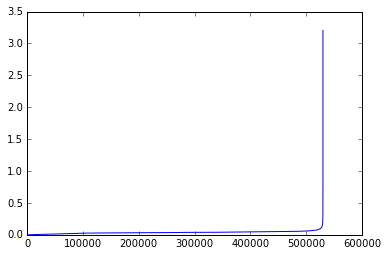

0.24729335514872686

In [185]:
score_gini(y_hat)

In [175]:
area_lorentz_fast(y, y_hat, )

0.29259409547108772

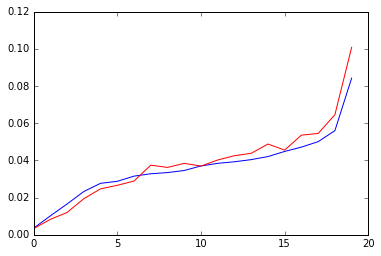

In [182]:
def mean_of_percentile(x, y, n):
    size = x.shape[0]
    xr = np.zeros(n)
    yr = np.zeros(n)
    quantile_size = size / n
    x_sorted = np.argsort(x)
    xcs = np.cumsum(x[x_sorted])
    ycs = np.cumsum(y[x_sorted])
    for i in range(n):
        xr[i] = (xcs[int((i + 1) * quantile_size - 1)] - xcs[int(i * quantile_size)]) / quantile_size
        yr[i] = (ycs[int((i + 1) * quantile_size - 1)] - ycs[int(i * quantile_size)]) / quantile_size
    return (xr, yr)
        
q = 20
xr, yr = mean_of_percentile(y_hat, y, q)
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(q), xr)
ax = fig.add_subplot(111)
line, = ax.plot(range(q), yr, color='red')
plt.show()

In [ ]:
trailing_errors = moving_average(errors, 1000)

print('minimum achieved at :', np.argmin(errors))
print('lambda : ', l[-1])
print('error : ', errors[-1])
print(i, 'th iteration')
print('intercept : ', intercept)
print('Trailing error : ', trailing_errors[-1:])
print('NB of non null coefficients : ', np.count_nonzero(np.greater(coeffs, 0.01)))
e = score('dde_freq.ml', p, intercept, coeffs)
print("Sum of log10 abs error : ", log10(e))

fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(errors + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(trailing_errors + 1e-20), color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.ones(len(errors))*np.log10(e), color='green')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(l + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(trailing_errors + 1e-20)[:len(l)], color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.ones(len(l))*np.log10(l[-1] + 1e-20), color='green')
plt.show()

In [ ]:
list(map(exp, [-5.030264, 0.224434, 0.102548]))

In [ ]:
list(map(exp, [-4.94434250637, 0.21366719,  0.0945649]))

In [ ]:
exp(-5.030264 + 3 * 0.224434 +  5 * 0.102548)

In [ ]:
exp(-4.94434250637 + 3 * 0.21366719 + 8 * 0.0945649)

In [157]:
df = pd.read_csv(mhr_dataset_filename, nrows=10000)

for i, name in enumerate(list(df)):
    print(i, name, df.dtypes[i], len(df[name].unique()))

0 EXT_dens_pop float64 21
1 EXT_part_respr_1p float64 12
2 EXT_part_respr_5p float64 21
3 EXT_part_secocc float64 13
4 EXT_part_surf_inf40 float64 17
5 EXT_part_surf_plus100 float64 21
6 EXT_part_rev_15K29k float64 21
7 EXT_part_men_lochlm float64 14
8 EXT_part_men_pror float64 21
9 EXT_part_pop_18a24a float64 12
10 EXT_part_pop_65a79a float64 16
11 EXT_part_respr_chauf_aut float64 17
12 EXT_part_respr_chauf_col float64 15
13 EXT_part_respr_chauf_ind float64 21
14 EXT_part_respr_chauf_indelec float64 21
15 EXT_part_repsr_sdb1 float64 9
16 EXT_part_repsr_sdb2 float64 9
17 EXT_part_lgt_co float64 21
18 EXT_part_lgt_vac float64 14
19 EXT_part_pop_15dipsup float64 18
20 EXT_part_pop_15ssdip float64 20
21 EXT_gdeville object 11
22 AUTV_prix_sra_max object 7
23 AUTV_prix_sra_min object 7
24 AUTV_rm object 2
25 AUTV_segment_max object 7
26 AUTV_segment_min object 7
27 CLI_banque object 25
28 POL_cdopmrh object 7
29 POL_fract int64 3
30 POL_cdregion int64 6
31 HAB_cdresid object 2
32 CLI_sex o

In [136]:
df.POL_fract.value_counts()

1     18
12     2
Name: POL_fract, dtype: int64

In [186]:
import test

ok
